<a href="https://colab.research.google.com/github/diegorabelorn/datastructure/blob/main/Dijkstra_Classic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**OBJETIVO**

Avaliar tempo de execução e pegada de carbono (CO₂) das seguintes abordagens de caminho mínimo:

**DESCRIÇÃO DO PROBLEMA**

1. Gerar grafos ponderados e conectados com o networkx em diferentes tamanhos, indo até 100.000 nós (ou o máximo suportado pela sua máquina).

2. Para cada grafo, escolher 5 nós aleatórios e calcular o caminho mínimo desses nós para todos os demais nós.

3. Repetir o experimento 15 a 20 vezes por tamanho (trocando os 5 nós a cada repetição) para robustez estatística.

4. Medir e registrar para cada execução:
Tempo (s);
CO₂ com CodeCarbon.

5. Calcular Intervalos de Confiança para as médias de tempo e CO₂.

6. Gerar gráficos e tabelas comparativas e salvá-los no repositório.

**CONFIGURAÇÃO EXPERIMENTAL**

7. Tamanhos sugeridos: [100, 500, 1_000, 5_000, 10_000, 50_000, 100_000].

8. Reprodutibilidade: fixe sementes (numpy e random).

9. Geração de grafos: nx.gnp_random_graph(n, p) com pesos inteiros positivos (ex.: 1..10).
Garanta conectividade (ex.: use o componente gigante quando necessário).

10. 15–20 repetições por tamanho; 5 fontes por repetição.

**MÉTRICAS E ESTATÍSTICAS**

transformar os dados brutos coletados (tempos e emissões de CO₂ de cada execução) em informações estatisticamente interpretáveis.
O objetivo é comparar o desempenho dos algoritmos a partir das médias e desvios-padrão das execuções.

Para cada par (tamanho do grafo, algoritmo), calcule: Média e Desvio Padrão.
Para cada algoritmo e tamanho de grafo, plote:

Eixo X: número de nós do grafo
Eixo Y: tempo médio (ou CO₂ médio)
Uma linha para cada algoritmo
Barras verticais indicando a variação

**ENTREGÁVEIS**
Repositório GitHub contendo:
- Notebook .ipynb com código, análises, gráficos salvos (.png/.svg) e tabelas (.csv);
- README.md explicando metodologia, resultados e link do vídeo;
- Vídeo (até 10min) Explique rapidamente os algoritmos, mostre a execução, apresente gráficos e discuta resultados. Sugestão de ferramentas (Loom e Youtube).
- Organização clara e reprodutível (seções, funções, seeds).


**DIJKSTRA CLÁSSICO**

In [ ]:
!pip install codecarbon networkx

PARTE 1 - Importação e função



In [1]:
import networkx as nx
import random
import time
import math
from codecarbon import EmissionsTracker
import sys
import pandas as pd
import numpy as np
from scipy import stats # Importação para o cálculo do IC

# Aumenta o limite de recursão
sys.setrecursionlimit(2000)

# =================================================================
# Implementação do Dijkstra Clássico (O(V^2 + E) Time)
# =================================================================

def getVertexWithMinDistance(distances, visited):
    """Função auxiliar O(V) para encontrar o nó não visitado com a menor distância conhecida."""
    currentMinDistance = float("inf")
    vertex = -1
    for vertexIdx, distance in enumerate(distances):
        if vertexIdx in visited:
            continue
        if distance <= currentMinDistance:
            vertex = vertexIdx
            currentMinDistance = distance
    return vertex, currentMinDistance

def dijkstrasAlgorithmClassic(start, edges):
    """Implementação do Dijkstra Clássico O(V^2)."""
    numberOfVertices = len(edges)
    minDistances = [float("inf") for _ in range(numberOfVertices)]
    minDistances[start] = 0
    visited = set()

    while len(visited) != numberOfVertices:
        vertex, currentMinDistance = getVertexWithMinDistance(minDistances, visited)
        if currentMinDistance == float("inf"):
            break
        visited.add(vertex)

        for edge in edges[vertex]:
            destination, distanceToDestination = edge
            if destination in visited:
                continue
            newPathDistance = currentMinDistance + distanceToDestination
            if newPathDistance < minDistances[destination]:
                minDistances[destination] = newPathDistance

    return [x if x != float("inf") else -1 for x in minDistances]



PARTE 2 - Configuração e impressão

In [17]:
# =================================================================
# CONFIGURAÇÃO DO EXPERIMENTO
# =================================================================

GRAPH_SIZES = [100, 500, 1000, 5000, 10000]
NUM_REPETITIONS = 15
NODES_PER_EXPERIMENT = 5
PROBABILITY = 0.02
CONFIDENCE_LEVEL = 0.95 # Nível de confiança desejado
FIXED_SEED = 42 # Semente fixa para reprodutibilidade

# Inicializa o DataFrame que armazenará as estatísticas finais por V
summary_results_classic = pd.DataFrame(columns=[
    'V', 'Média Tempo (s)', 'DP Tempo (s)', 'Média CO2e (kg)', 'DP CO2e (kg)'
])

# =================================================================
# LOOP PRINCIPAL: Itera sobre os tamanhos de grafo (V)
# =================================================================

print("Iniciando a avaliação do Dijkstra Clássico (O(V^2)) com Intervalos de Confiança...")
print("===================================================================================")

for V in GRAPH_SIZES:

    # REQUISITO ATENDIDO: Fixa as sementes antes de cada tamanho de grafo
    random.seed(FIXED_SEED)
    np.random.seed(FIXED_SEED)
    # A geração de grafo NetworkX também usará o estado do random.seed

    print(f"\n[Fase de Grafo V={V}]")

    temp_prob = PROBABILITY

    # 1. Geração do Grafo ponderados e conectados com networkx
    G = None
    while True:
        random_seed = int(V * time.time())
        G = nx.gnp_random_graph(n=V, p=temp_prob, seed=FIXED_SEED)

        if nx.is_connected(G):
            break
        temp_prob += 0.01
        if temp_prob > 0.1:
            print(f"Aviso: Não foi possível garantir conectividade para V={V} com p<0.1.")
            break

    # Adiciona pesos e converte para lista de adjacência
    for u, v in G.edges():
        G[u][v]['weight'] = random.randint(1, 10)

    edges_list = [[] for _ in range(V)]
    for u, v, data in G.edges(data=True):
        weight = data.get('weight', 1)
        edges_list[u].append([v, weight])
        if not G.is_directed():
             edges_list[v].append([u, weight])

    E = G.number_of_edges()
    print(f"Grafo gerado: V={V}, E={E}.")

    table_data = []

    # =================================================================
    # LOOP SECUNDÁRIO: REPETE O EXPERIMENTO 15 VEZES (Gera 15 linhas)
    # =================================================================

    # 2. Escolhe 5 nós aleatórios e chama a função dijkstrasAlgorithmClassic para calcular o caminho mínimo
    # 3. Repete o experimento 15 vezes (trocando os 5 nós a cada repetição)

    for rep_num in range(1, NUM_REPETITIONS + 1):

        print(f"  -> Repetição {rep_num}/{NUM_REPETITIONS} (V={V}) em andamento...", end='\r')


        random_starts = random.sample(range(V), min(V, NODES_PER_EXPERIMENT))

        total_time = 0
        total_emissions = 0

        # =================================================================
        # LOOP INTERNO: EXECUTA DIJKSTRA PARA CADA UM DOS 5 NÓS
        # =================================================================
        for start_node in random_starts:

            # 4. Medição do tempo(s) e CO2
            tracker = EmissionsTracker(output_dir=".", save_to_file=False, log_level="error")
            tracker.start()
            start_time = time.time()

            _ = dijkstrasAlgorithmClassic(start_node, edges_list)

            end_time = time.time()
            emissions = tracker.stop()

            total_time += (end_time - start_time)
            total_emissions += emissions if emissions is not None else 0

        # Cálculo da Média da Repetição (dividido por 5)
        avg_time = total_time / NODES_PER_EXPERIMENT
        avg_co2e = total_emissions / NODES_PER_EXPERIMENT

        # Adiciona a linha à tabela DESTE V
        table_data.append({
            'Repeticao': rep_num,
            'Nos Usados': str(sorted(random_starts)),
            'Tempo (s)': avg_time,
            'CO2e (kg)': avg_co2e
        })

    print(" " * 80, end='\r') # Limpa a linha de progresso


    # 5. CÁLCULO DOS INTERVALOS DE CONFIANÇA (IC 95%)
    df = pd.DataFrame(table_data)
    nome_csv_detalhe = f"detalhe_classic_V{V}.csv"
    df.to_csv(nome_csv_detalhe, index=False)
    print(f"\n[Exportado: {nome_csv_detalhe}]")

    # Extrai as 15 amostras de cada repetição
    time_samples = df['Tempo (s)'].values
    co2e_samples = df['CO2e (kg)'].values
    n = len(time_samples)

    if n > 1:
        # Estatísticas: Média Geral e Desvio Padrão Amostral (ddof=1)
        mean_time = np.mean(time_samples)
        std_time = np.std(time_samples, ddof=1)
        mean_co2e = np.mean(co2e_samples)
        std_co2e = np.std(co2e_samples, ddof=1)

        # Valor crítico t de Student para 95% de confiança e n-1 graus de liberdade
        df_t = n - 1
        t_critical = stats.t.ppf(1 - (1 - CONFIDENCE_LEVEL) / 2, df_t)

        # Margem de Erro (ME = t * (s / sqrt(n)))
        me_time = t_critical * (std_time / np.sqrt(n))
        me_co2e = t_critical * (std_co2e / np.sqrt(n))

        # Intervalo de Confiança (IC = Média +/- ME)
        ic_time_str = f"[{mean_time - me_time:.6f} s, {mean_time + me_time:.6f} s]"
        ic_co2e_str = f"[{mean_co2e - me_co2e:.10f} kg, {mean_co2e + me_co2e:.10f} kg]"

       # Adiciona as estatísticas agregadas ao DataFrame resumo
        summary_results_classic.loc[len(summary_results_classic)] = [
          V,
          mean_time,
          std_time,
          mean_co2e,
          std_co2e
        ]

    else:
        # Caso de erro (não deveria ocorrer com n=15)
        mean_time, mean_co2e = 0, 0
        ic_time_str = "N/A (amostra muito pequena)"
        ic_co2e_str = "N/A (amostra muito pequena)"

    # =================================================================
    # RESULTADO: Impressão da Tabela e do IC
    # =================================================================



    print("\n" + "="*70)
    print(f"TABELA DE ROBUSTEZ ESTATÍSTICA: DIJKSTRA O(V²) | V = {V} NÓS")
    print("Média do Tempo e CO₂ de 5 execuções aleatórias por repetição.")
    print("="*70)

    # Imprime os Intervalos de Confiança
    print(f"- Média Geral (Tempo) das 15 repetições: {mean_time:.6f} s")
    print(f"Desvio Padrão (Tempo): {std_time:.9f} s")
    print(f"Intervalo de Confiança 95% (Tempo): {ic_time_str}")
    print(f"\n- Média Geral (CO₂e) das 15 repetições: {mean_co2e:.10f} kg")
    print(f"Desvio Padrão (CO₂e): {std_co2e:.9f} kg")
    print(f"Intervalo de Confiança 95% (CO₂e): {ic_co2e_str}")
    print("-" * 70)


    # Formata a tabela para impressão
    df['Tempo (s)'] = df['Tempo (s)'].map('{:.6f}'.format)
    df['CO2e (kg)'] = df['CO2e (kg)'].map('{:.10f}'.format)

    print(df.to_markdown(index=False))
    print("\n" + "="*70 + "\n") # Separador entre tabelas


Iniciando a avaliação do Dijkstra Clássico (O(V^2)) com Intervalos de Confiança...

[Fase de Grafo V=100]
Grafo gerado: V=100, E=224.
                                                                                
[Exportado: detalhe_classic_V100.csv]

TABELA DE ROBUSTEZ ESTATÍSTICA: DIJKSTRA O(V²) | V = 100 NÓS
Média do Tempo e CO₂ de 5 execuções aleatórias por repetição.
- Média Geral (Tempo) das 15 repetições: 0.001119 s
Desvio Padrão (Tempo): 0.000093871 s
Intervalo de Confiança 95% (Tempo): [0.001067 s, 0.001171 s]

- Média Geral (CO₂e) das 15 repetições: 0.0000000167 kg
Desvio Padrão (CO₂e): 0.000000002 kg
Intervalo de Confiança 95% (CO₂e): [0.0000000159 kg, 0.0000000176 kg]
----------------------------------------------------------------------
|   Repeticao | Nos Usados           |   Tempo (s) |   CO2e (kg) |
|------------:|:---------------------|------------:|------------:|
|           1 | [45, 52, 54, 59, 93] |    0.00109  |    1.69e-08 |
|           2 | [6, 12, 82, 83, 86]  

PARTE 3 - Tabela Resumo

In [19]:
# Formata o DataFrame de resumo

# Adicionado: Conversão forçada para float para evitar o ValueError em ambientes de notebook
for col in ['Média Tempo (s)', 'DP Tempo (s)', 'Média CO2e (kg)', 'DP CO2e (kg)']:
    try:
        summary_results_classic[col] = summary_results_classic[col].astype(float)
    except ValueError:
        # Ignora se já for string ou se o erro for outro.
        pass

summary_results_classic['Média Tempo (s)'] = summary_results_classic['Média Tempo (s)'].map('{:.6f}'.format)
summary_results_classic['DP Tempo (s)'] = summary_results_classic['DP Tempo (s)'].map('{:.9f}'.format)
summary_results_classic['Média CO2e (kg)'] = summary_results_classic['Média CO2e (kg)'].map('{:.10f}'.format)
summary_results_classic['DP CO2e (kg)'] = summary_results_classic['DP CO2e (kg)'].map('{:.12f}'.format)

print(summary_results_classic.to_markdown(index=False))

# EXPORTAR CSV DA TABELA RESUMO
summary_results_classic.to_csv("resumo_classic.csv", index=False)
print("\n[Exportado: resumo_classic.csv]")

|     V |   Média Tempo (s) |   DP Tempo (s) |   Média CO2e (kg) |   DP CO2e (kg) |
|------:|------------------:|---------------:|------------------:|---------------:|
|   100 |          0.001119 |     9.3871e-05 |       1.67e-08    |    1.518e-09   |
|   500 |          0.022718 |     0.00250426 |       2.173e-07   |    2.6452e-08  |
|  1000 |          0.098481 |     0.0112044  |       9.195e-07   |    1.13801e-07 |
|  5000 |          2.45767  |     0.135949   |       2.30332e-05 |    1.27457e-06 |
| 10000 |          9.9253   |     0.184681   |       9.2988e-05  |    1.73005e-06 |

[Exportado: resumo_classic.csv]


**DIJKSTRA COM MINI-HEAP**

PARTE 4 - CLASSE E FUNÇÕES

In [20]:
class MinHeap:
    # (O código da sua classe MinHeap: __init__, isEmpty, buildHeap, siftDown, siftUp, remove, swap, update deve ser inserido aqui)
    # NOTE: O código da classe MinHeap e seus métodos não foram incluídos aqui para brevidade,
    # mas eles devem estar definidos no ambiente de execução.
    # Assumimos que a classe MinHeap está corretamente definida acima deste bloco.

    def __init__(self, array):
        self.vertexMap = {idx: idx for idx in range(len(array))}
        self.heap = self.buildHeap(array)

    def isEmpty(self):
        return len(self.heap) == 0

    def buildHeap(self, array):
        firstParentIdx = (len(array) - 2) // 2
        for currentIdx in reversed(range(firstParentIdx + 1)):
            self.siftDown(currentIdx, len(array) - 1, array)
        return array

    def siftDown(self, currentIdx, endIdx, heap):
        childOneIdx = currentIdx * 2 + 1
        while childOneIdx <= endIdx:
            childTwoIdx = currentIdx * 2 + 2 if currentIdx * 2 + 2 <= endIdx else -1
            if childTwoIdx != -1 and heap[childTwoIdx][1] < heap[childOneIdx][1]:
                idxToSwap = childTwoIdx
            else:
                idxToSwap = childOneIdx
            if heap[idxToSwap][1] < heap[currentIdx][1]:
                self.swap(currentIdx, idxToSwap, heap)
                currentIdx = idxToSwap
                childOneIdx = currentIdx * 2 + 1
            else:
                return

    def siftUp(self, currentIdx, heap):
        parentIdx = (currentIdx - 1) // 2
        while currentIdx > 0 and heap[currentIdx][1] < heap[parentIdx][1]:
            self.swap(currentIdx, parentIdx, heap)
            currentIdx = parentIdx
            parentIdx = (currentIdx - 1) // 2

    def remove(self):
        if self.isEmpty():
            return None

        self.swap(0, len(self.heap) - 1, self.heap)
        vertex, distance = self.heap.pop()
        self.vertexMap.pop(vertex)
        self.siftDown(0, len(self.heap) - 1, self.heap)
        return vertex, distance

    def swap(self, i, j, heap):
        self.vertexMap[heap[i][0]] = j
        self.vertexMap[heap[j][0]] = i
        heap[i], heap[j] = heap[j], heap[i]

    def update(self, vertex, value):
        self.heap[self.vertexMap[vertex]] = (vertex, value)
        self.siftUp(self.vertexMap[vertex], self.heap)

def dijkstrasAlgorithm(start, edges):
    """Implementação do Dijkstra Otimizado O((V+E)logV)."""
    numberOfVertices = len(edges)
    minDistances = [float("inf") for _ in range(numberOfVertices)]
    minDistances[start] = 0

    minDistancesHeap = MinHeap([(idx, float("inf")) for idx in range(numberOfVertices)])
    minDistancesHeap.update(start, 0)

    while not minDistancesHeap.isEmpty():
        vertex, currentMinDistance = minDistancesHeap.remove()

        if currentMinDistance == float("inf"):
            break

        for edge in edges[vertex]:
            destination, distanceToDestination = edge
            newPathDistance = currentMinDistance + distanceToDestination
            currentDestinationDistance = minDistances[destination]

            if newPathDistance < currentDestinationDistance:
                minDistances[destination] = newPathDistance
                minDistancesHeap.update(destination, newPathDistance)

    return list(map(lambda x: -1 if x == float("inf") else x, minDistances))

PARTE 5 - Configuração e impressão

In [21]:
# =================================================================
# CONFIGURAÇÃO E EXECUÇÃO DO EXPERIMENTO
# =================================================================

summary_results_miniheap = pd.DataFrame(columns=[
    'V', 'Média Tempo (s)', 'DP Tempo (s)', 'Média CO2e (kg)', 'DP CO2e (kg)'
])

print("Iniciando a avaliação do Dijkstra Otimizado (O((V+E)logV)) com coleta de estatísticas...")
print("========================================================================================")

for V in GRAPH_SIZES:

    # Fixa as sementes
    random.seed(FIXED_SEED)
    np.random.seed(FIXED_SEED)

    print(f"\n[Fase de Grafo V={V}]")

    temp_prob = PROBABILITY

    # Geração do Grafo Conectado e Ponderado
    G = None
    while True:
        G = nx.gnp_random_graph(n=V, p=temp_prob, seed=FIXED_SEED)
        if nx.is_connected(G):
            break
        temp_prob += 0.01
        if temp_prob > 0.1:
            print(f"Aviso: Não foi possível garantir conectividade para V={V} com p<0.1.")
            break

    # Adiciona pesos e converte para lista de adjacência
    for u, v in G.edges():
        G[u][v]['weight'] = random.randint(1, 10)

    edges_list = [[] for _ in range(V)]
    for u, v, data in G.edges(data=True):
        weight = data.get('weight', 1)
        edges_list[u].append([v, weight])
        if not G.is_directed():
             edges_list[v].append([u, weight])

    E = G.number_of_edges()
    print(f"Grafo gerado: V={V}, E={E}.")

    table_data = []

    # LOOP SECUNDÁRIO: REPETE O EXPERIMENTO 15 VEZES
    for rep_num in range(1, NUM_REPETITIONS + 1):

        print(f"  -> Repetição {rep_num}/{NUM_REPETITIONS} (V={V}) em andamento...", end='\r')

        # Seleção de 5 novos nós aleatórios (usa a semente fixa)
        random_starts = random.sample(range(V), min(V, NODES_PER_EXPERIMENT))

        total_time = 0
        total_emissions = 0

        # LOOP INTERNO: EXECUTA DIJKSTRA PARA CADA UM DOS 5 NÓS
        for start_node in random_starts:

            tracker = EmissionsTracker(output_dir=".", save_to_file=False, log_level="error")
            tracker.start()
            start_time = time.time()

            # CHAMA A FUNÇÃO DIJKSTRA OTIMIZADA
            _ = dijkstrasAlgorithm(start_node, edges_list)

            end_time = time.time()
            emissions = tracker.stop()

            total_time += (end_time - start_time)
            total_emissions += emissions if emissions is not None else 0

        # Cálculo da Média da Repetição (dividido por 5)
        avg_time = total_time / NODES_PER_EXPERIMENT
        avg_co2e = total_emissions / NODES_PER_EXPERIMENT

        table_data.append({
            'Nº Repetição': rep_num,
            'Nós Usados': str(sorted(random_starts)),
            'Tempo (s)': avg_time,
            'CO2e (kg)': avg_co2e
        })

    print(" " * 80, end='\r')

    # =================================================================
    # CÁLCULO DAS ESTATÍSTICAS E IMPRESSÃO
    # =================================================================

    df_detail = pd.DataFrame(table_data)
    time_samples = df_detail['Tempo (s)'].values
    co2e_samples = df_detail['CO2e (kg)'].values
    n = len(time_samples)

    if n > 1:
        mean_time = np.mean(time_samples)
        std_time = np.std(time_samples, ddof=1)
        mean_co2e = np.mean(co2e_samples)
        std_co2e = np.std(co2e_samples, ddof=1)

        # Adiciona as estatísticas agregadas ao DataFrame resumo
        summary_results_miniheap.loc[len(summary_results_miniheap)] = [V, mean_time, std_time, mean_co2e, std_co2e]

        # Cálculo do IC 95%
        df_t = n - 1
        t_critical = stats.t.ppf(1 - (1 - CONFIDENCE_LEVEL) / 2, df_t)
        me_time = t_critical * (std_time / np.sqrt(n))
        me_co2e = t_critical * (std_co2e / np.sqrt(n))
        ic_time_str = f"[{mean_time - me_time:.6f} s, {mean_time + me_time:.6f} s]"
        ic_co2e_str = f"[{mean_co2e - me_co2e:.10f} kg, {mean_co2e + me_co2e:.10f} kg]"

    else:
        ic_time_str = "N/A"
        ic_co2e_str = "N/A"

    # EXPORTAR CSV DA TABELA DETALHADA
    nome_csv_detalhe = f"detalhe_miniheap_V{V}.csv"
    df_detail.to_csv(nome_csv_detalhe, index=False)
    print(f"\n[Exportado: {nome_csv_detalhe}]")

    # Impressão da Tabela Detalhada e IC
    print("\n" + "="*70)
    print(f"TABELA DE ROBUSTEZ ESTATÍSTICA: DIJKSTRA O((V+E)logV) | V = {V} NÓS")
    print("=======================================================================")

    print(f"Média Geral (Tempo) das 15 repetições: {mean_time:.6f} s")
    print(f"Desvio Padrão (Tempo): {std_time:.9f} s")
    print(f"Intervalo de Confiança 95% (Tempo): {ic_time_str}")

    print(f"\nMédia Geral (CO₂e) das 15 repetições: {mean_co2e:.10f} kg")
    print(f"Desvio Padrão (CO₂e): {std_co2e:.12f} kg")
    print(f"Intervalo de Confiança 95% (CO₂e): {ic_co2e_str}")
    print("-" * 70)

    df_detail['Tempo (s)'] = df_detail['Tempo (s)'].map('{:.6f}'.format)
    df_detail['CO2e (kg)'] = df_detail['CO2e (kg)'].map('{:.10f}'.format)
    print(df_detail.to_markdown(index=False))
    print("\n" + "="*70 + "\n")

Iniciando a avaliação do Dijkstra Otimizado (O((V+E)logV)) com coleta de estatísticas...

[Fase de Grafo V=100]
Grafo gerado: V=100, E=224.
                                                                                
[Exportado: detalhe_miniheap_V100.csv]

TABELA DE ROBUSTEZ ESTATÍSTICA: DIJKSTRA O((V+E)logV) | V = 100 NÓS
Média Geral (Tempo) das 15 repetições: 0.000895 s
Desvio Padrão (Tempo): 0.000076605 s
Intervalo de Confiança 95% (Tempo): [0.000852 s, 0.000937 s]

Média Geral (CO₂e) das 15 repetições: 0.0000000145 kg
Desvio Padrão (CO₂e): 0.000000001221 kg
Intervalo de Confiança 95% (CO₂e): [0.0000000138 kg, 0.0000000152 kg]
----------------------------------------------------------------------
|   Nº Repetição | Nós Usados           |   Tempo (s) |   CO2e (kg) |
|---------------:|:---------------------|------------:|------------:|
|              1 | [45, 52, 54, 59, 93] |    0.000974 |    1.6e-08  |
|              2 | [6, 12, 82, 83, 86]  |    0.000815 |    1.39e-08 |
|      

PARTE 6 - Tabela Resumo

In [22]:
# Adicionado: Conversão forçada para float para evitar o ValueError
for col in ['Média Tempo (s)', 'DP Tempo (s)', 'Média CO2e (kg)', 'DP CO2e (kg)']:
    try:
        summary_results_miniheap[col] = summary_results_miniheap[col].astype(float)
    except ValueError:
        pass

# Aplicar a formatação (o .map deve funcionar após a garantia da tipagem)
summary_results_miniheap['Média Tempo (s)'] = summary_results_miniheap['Média Tempo (s)'].map('{:.6f}'.format)
summary_results_miniheap['DP Tempo (s)'] = summary_results_miniheap['DP Tempo (s)'].map('{:.9f}'.format)
summary_results_miniheap['Média CO2e (kg)'] = summary_results_miniheap['Média CO2e (kg)'].map('{:.10f}'.format)
summary_results_miniheap['DP CO2e (kg)'] = summary_results_miniheap['DP CO2e (kg)'].map('{:.12f}'.format)

# Imprime a tabela
print(summary_results_miniheap.to_markdown(index=False))

# EXPORTAR CSV DA TABELA RESUMO
summary_results_miniheap.to_csv("resumo_miniheap.csv", index=False)
print("\n[Exportado: resumo_miniheap.csv]")

|     V |   Média Tempo (s) |   DP Tempo (s) |   Média CO2e (kg) |   DP CO2e (kg) |
|------:|------------------:|---------------:|------------------:|---------------:|
|   100 |          0.000895 |    7.6605e-05  |        1.45e-08   |    1.221e-09   |
|   500 |          0.005046 |    0.000585183 |        5.34e-08   |    6.234e-09   |
|  1000 |          0.01282  |    0.00111028  |        1.271e-07  |    1.0308e-08  |
|  5000 |          0.167496 |    0.011294    |        1.5257e-06 |    1.00011e-07 |
| 10000 |          0.638813 |    0.0218539   |        5.992e-06  |    2.04548e-07 |

[Exportado: resumo_miniheap.csv]


**ALGORITMO DE REFERÊNCIA DO NETWORKX**

PARTE 7 - Lógica do NetworkX

In [23]:
summary_results_nx = pd.DataFrame(columns=[
    'V', 'Média Tempo (s)', 'DP Tempo (s)', 'Média CO2e (kg)', 'DP CO2e (kg)'
])

print("\n\nIniciando a avaliação da Função de Referência do NetworkX (O((V+E)logV))...")
print("==============================================================================")

for V in GRAPH_SIZES:

    # Fixa as sementes (REQUISITO DE REPRODUTIBILIDADE)
    random.seed(FIXED_SEED)
    np.random.seed(FIXED_SEED)

    print(f"\n[Fase de Grafo V={V}]")

    temp_prob = PROBABILITY

    # Geração do Grafo (IDÊNTICO AOS ANTERIORES)
    G = None
    while True:
        # Usa o FIXED_SEED para garantir que o grafo seja o mesmo
        G = nx.gnp_random_graph(n=V, p=temp_prob, seed=FIXED_SEED)
        if nx.is_connected(G):
            break
        temp_prob += 0.01
        if temp_prob > 0.1:
            print(f"Aviso: Não foi possível garantir conectividade para V={V} com p<0.1.")
            break

    # Adiciona pesos
    for u, v in G.edges():
        G[u][v]['weight'] = random.randint(1, 10)

    E = G.number_of_edges()
    print(f"Grafo gerado: V={V}, E={E}.")

    table_data = []

    # LOOP SECUNDÁRIO: REPETE O EXPERIMENTO 15 VEZES
    for rep_num in range(1, NUM_REPETITIONS + 1):

        print(f"  -> Repetição {rep_num}/{NUM_REPETITIONS} (V={V}) em andamento...", end='\r')

        # Seleção de 5 novos nós aleatórios
        random_starts = random.sample(range(V), min(V, NODES_PER_EXPERIMENT))

        total_time = 0
        total_emissions = 0

        # LOOP INTERNO: EXECUTA DIJKSTRA (NETWORKX) PARA CADA UM DOS 5 NÓS
        for start_node in random_starts:

            tracker = EmissionsTracker(output_dir=".", save_to_file=False, log_level="error")
            tracker.start()
            start_time = time.time()

            # CHAMADA DA FUNÇÃO DE REFERÊNCIA DO NETWORKX
            # Retorna (distâncias, caminhos), mas só precisamos do tempo
            distances, paths = nx.single_source_dijkstra(G, source=start_node, weight='weight')

            end_time = time.time()
            emissions = tracker.stop()

            total_time += (end_time - start_time)
            total_emissions += emissions if emissions is not None else 0

        # Cálculo da Média da Repetição (dividido por 5)
        avg_time = total_time / NODES_PER_EXPERIMENT
        avg_co2e = total_emissions / NODES_PER_EXPERIMENT

        table_data.append({
            'Nº Repetição': rep_num,
            'Nós Usados': str(sorted(random_starts)),
            'Tempo (s)': avg_time,
            'CO2e (kg)': avg_co2e
        })

    print(" " * 80, end='\r')

    # CÁLCULO DAS ESTATÍSTICAS E ATUALIZAÇÃO DO RESUMO
    df_detail = pd.DataFrame(table_data)
    time_samples = df_detail['Tempo (s)'].values
    co2e_samples = df_detail['CO2e (kg)'].values
    n = len(time_samples)

    if n > 1:
        mean_time = np.mean(time_samples)
        std_time = np.std(time_samples, ddof=1)
        mean_co2e = np.mean(co2e_samples)
        std_co2e = np.std(co2e_samples, ddof=1)

        # Adiciona as estatísticas agregadas ao DataFrame resumo
        summary_results_nx.loc[len(summary_results_nx)] = [V, mean_time, std_time, mean_co2e, std_co2e]

        # Cálculo e strings de IC
        df_t = n - 1
        t_critical = stats.t.ppf(1 - (1 - CONFIDENCE_LEVEL) / 2, df_t)
        me_time = t_critical * (std_time / np.sqrt(n))
        me_co2e = t_critical * (std_co2e / np.sqrt(n))
        ic_time_str = f"[{mean_time - me_time:.6f} s, {mean_time + me_time:.6f} s]"
        ic_co2e_str = f"[{mean_co2e - me_co2e:.10f} kg, {mean_co2e + me_co2e:.10f} kg]"

    else:
        ic_time_str = "N/A"
        ic_co2e_str = "N/A"

    # EXPORTAR CSV DA TABELA DETALHADA
    nome_csv_detalhe = f"detalhe_networkx_V{V}.csv"
    df_detail.to_csv(nome_csv_detalhe, index=False)
    print(f"\n[Exportado: {nome_csv_detalhe}]")

    # Impressão da Tabela Detalhada e IC
    print("\n" + "="*70)
    print(f"TABELA DE ROBUSTEZ ESTATÍSTICA: NETWORKX REFERENCE | V = {V} NÓS")
    print("=======================================================================")

    print(f"Média Geral (Tempo) das 15 repetições: {mean_time:.6f} s")
    print(f"Desvio Padrão (Tempo): {std_time:.9f} s")
    print(f"Intervalo de Confiança 95% (Tempo): {ic_time_str}")

    print(f"\nMédia Geral (CO₂e) das 15 repetições: {mean_co2e:.10f} kg")
    print(f"Desvio Padrão (CO₂e): {std_co2e:.12f} kg")
    print(f"Intervalo de Confiança 95% (CO₂e): {ic_co2e_str}")
    print("-" * 70)

    df_detail['Tempo (s)'] = df_detail['Tempo (s)'].map('{:.6f}'.format)
    df_detail['CO2e (kg)'] = df_detail['CO2e (kg)'].map('{:.10f}'.format)
    print(df_detail.to_markdown(index=False))
    print("\n" + "="*70 + "\n")



Iniciando a avaliação da Função de Referência do NetworkX (O((V+E)logV))...

[Fase de Grafo V=100]
Grafo gerado: V=100, E=224.
                                                                                
[Exportado: detalhe_networkx_V100.csv]

TABELA DE ROBUSTEZ ESTATÍSTICA: NETWORKX REFERENCE | V = 100 NÓS
Média Geral (Tempo) das 15 repetições: 0.000713 s
Desvio Padrão (Tempo): 0.000260846 s
Intervalo de Confiança 95% (Tempo): [0.000569 s, 0.000857 s]

Média Geral (CO₂e) das 15 repetições: 0.0000000142 kg
Desvio Padrão (CO₂e): 0.000000004336 kg
Intervalo de Confiança 95% (CO₂e): [0.0000000118 kg, 0.0000000166 kg]
----------------------------------------------------------------------
|   Nº Repetição | Nós Usados           |   Tempo (s) |   CO2e (kg) |
|---------------:|:---------------------|------------:|------------:|
|              1 | [45, 52, 54, 59, 93] |    0.001523 |    2.87e-08 |
|              2 | [6, 12, 82, 83, 86]  |    0.000616 |    1.27e-08 |
|              3 | [7

PARTE 8 - TABELA RESUMO

In [24]:
# Conversão forçada para float para evitar o ValueError em ambientes de notebook
for col in ['Média Tempo (s)', 'DP Tempo (s)', 'Média CO2e (kg)', 'DP CO2e (kg)']:
    try:
        summary_results_nx[col] = summary_results_nx[col].astype(float)
    except ValueError:
        pass

# Formata o DataFrame de resumo
summary_results_nx['Media Tempo (s)'] = summary_results_nx['Media Tempo (s)'].map('{:.6f}'.format)
summary_results_nx['DP Tempo (s)'] = summary_results_nx['DP Tempo (s)'].map('{:.9f}'.format)
summary_results_nx['Media CO2e (kg)'] = summary_results_nx['Media CO2e (kg)'].map('{:.10f}'.format)
summary_results_nx['DP CO2e (kg)'] = summary_results_nx['DP CO2e (kg)'].map('{:.12f}'.format)

print(summary_results_nx.to_markdown(index=False))

# NOVO: EXPORTAÇÃO CSV DA TABELA RESUMO
summary_results_nx.to_csv("resumo_networkx.csv", index=False)
print("\n[Exportado: resumo_networkx.csv]")

|     V |   Média Tempo (s) |   DP Tempo (s) |   Média CO2e (kg) |   DP CO2e (kg) |
|------:|------------------:|---------------:|------------------:|---------------:|
|   100 |          0.000713 |    0.000260846 |       1.42e-08    |    4.336e-09   |
|   500 |          0.004655 |    0.00103306  |       5.08e-08    |    1.3866e-08  |
|  1000 |          0.015254 |    0.0034027   |       1.472e-07   |    3.734e-08   |
|  5000 |          0.308148 |    0.0749723   |       2.8942e-06  |    7.02488e-07 |
| 10000 |          1.24296  |    0.0588678   |       1.16512e-05 |    5.51464e-07 |

[Exportado: resumo_networkx.csv]


PARTE 9 - TABELA COMPARATIVA

In [29]:
# Adiciona rótulos e Consolida
summary_results_classic['Algoritmo'] = 'Dijkstra Classico'
summary_results_miniheap['Algoritmo'] = 'Dijkstra MiniHeap'
summary_results_nx['Algoritmo'] = 'NetworkX'

# Consolida os resultados em um único DataFrame
df_consolidado = pd.concat([
    summary_results_classic,
    summary_results_miniheap,
    summary_results_nx
], ignore_index=True)

# Ordena o DataFrame: Agrupar por V e depois por Algoritmo
df_consolidado = df_consolidado.sort_values(by=['V', 'Algoritmo']).reset_index(drop=True)

# Seleciona e Renomeia as Colunas na Ordem Final Desejada
df_tabela = df_consolidado[[
    'Algoritmo',
    'V',
    'Média Tempo (s)',
    'DP Tempo (s)',
    'Média CO2e (kg)',
    'DP CO2e (kg)'
]].copy()

# Garante que os dados são float antes de formatar, para evitar o ValueError
for col in df_tabela.columns[2:]: # Pula 'Algoritmo' e 'V'
    try:
        df_tabela[col] = df_tabela[col].astype(float)
    except Exception:
        pass

# Define o formato de string para cada coluna numérica
df_tabela['Média Tempo (s)'] = df_tabela['Média Tempo (s)'].map('{:.6f}'.format)
df_tabela['DP Tempo (s)'] = df_tabela['DP Tempo (s)'].map('{:.9f}'.format)
df_tabela['Média CO2e (kg)'] = df_tabela['Média CO2e (kg)'].map('{:.10f}'.format)
df_tabela['DP CO2e (kg)'] = df_tabela['DP CO2e (kg)'].map('{:.12f}'.format)

# Imprime a tabela no formato Markdown
print(df_tabela.to_markdown(index=False))

NOME_ARQUIVO_CSV = "tabela_consolidada_final.csv"
df_tabela[[
    'Algoritmo', 'V', 'Média Tempo (s)', 'DP Tempo (s)', 'Média CO2e (kg)', 'DP CO2e (kg)'
]].to_csv(NOME_ARQUIVO_CSV, index=False)

print(f"\n Exportação CSV Concluída: '{NOME_ARQUIVO_CSV}'")

| Algoritmo         |     V |   Média Tempo (s) |   DP Tempo (s) |   Média CO2e (kg) |   DP CO2e (kg) |
|:------------------|------:|------------------:|---------------:|------------------:|---------------:|
| Dijkstra Classico |   100 |          0.001119 |    9.3871e-05  |       1.67e-08    |    1.518e-09   |
| Dijkstra MiniHeap |   100 |          0.000895 |    7.6605e-05  |       1.45e-08    |    1.221e-09   |
| NetworkX          |   100 |          0.000713 |    0.000260846 |       1.42e-08    |    4.336e-09   |
| Dijkstra Classico |   500 |          0.022718 |    0.00250426  |       2.173e-07   |    2.6452e-08  |
| Dijkstra MiniHeap |   500 |          0.005046 |    0.000585183 |       5.34e-08    |    6.234e-09   |
| NetworkX          |   500 |          0.004655 |    0.00103306  |       5.08e-08    |    1.3866e-08  |
| Dijkstra Classico |  1000 |          0.098481 |    0.0112044   |       9.195e-07   |    1.13801e-07 |
| Dijkstra MiniHeap |  1000 |          0.01282  |    0.00111028 

In [ ]:
PARTE 10 - GRÁFICOS

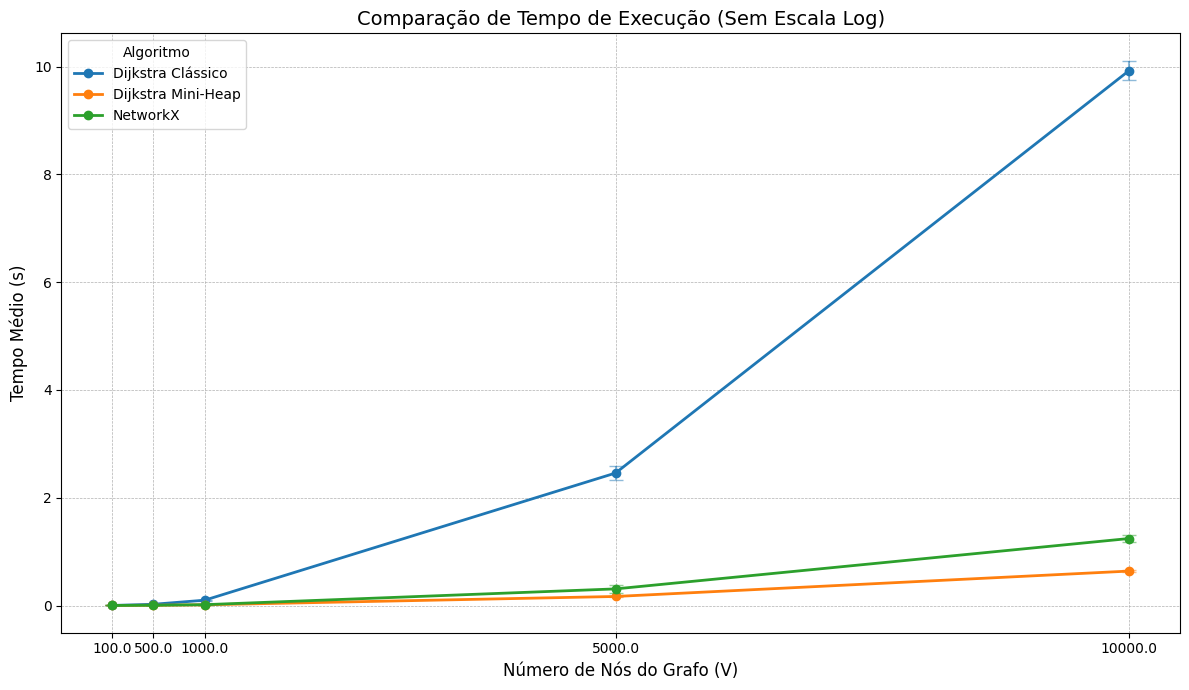

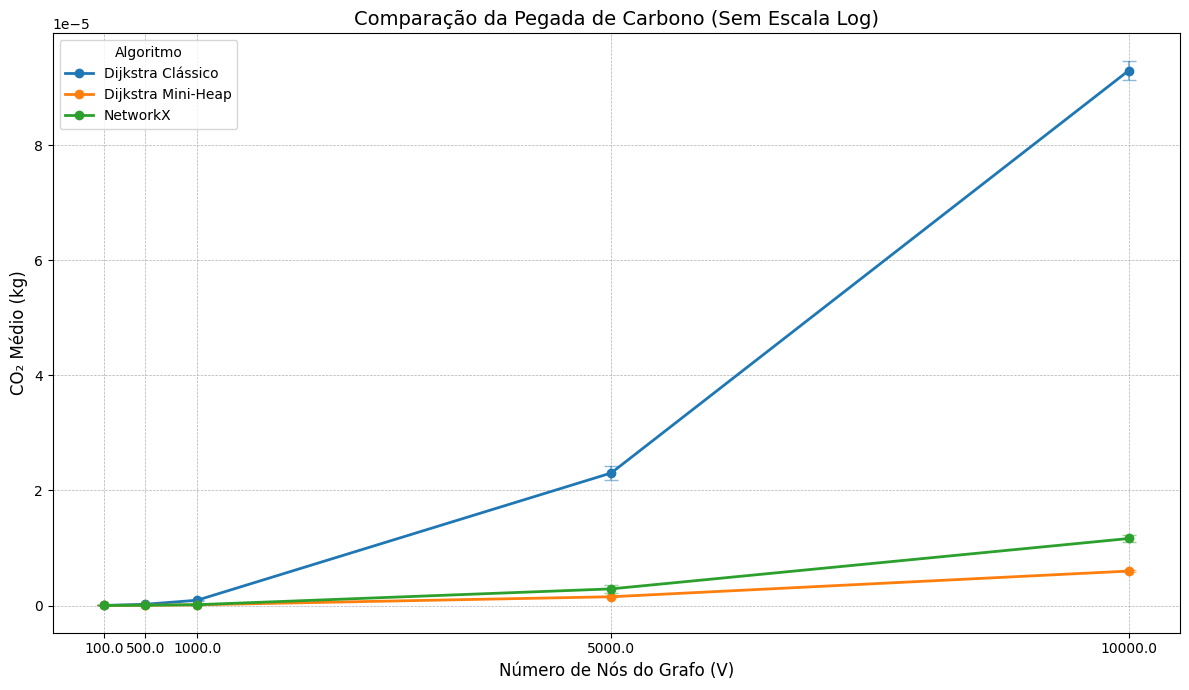

In [28]:
import matplotlib.pyplot as plt
# =================================================================
# CONSOLIDAÇÃO DOS DADOS
# =================================================================

# Adicionar a coluna 'Algoritmo'
# É crucial garantir que esta etapa não tenha sido feita nas células anteriores, ou que as colunas sejam float.
# Fazemos isso aqui para garantir que o tipo Algoritmo não se misture.
df_classic = summary_results_classic.copy()
df_miniheap = summary_results_miniheap.copy()
df_nx = summary_results_nx.copy()

df_classic['Algoritmo'] = 'Dijkstra Clássico'
df_miniheap['Algoritmo'] = 'Dijkstra Mini-Heap'
df_nx['Algoritmo'] = 'NetworkX'

# Concatena todos os DataFrames
df_consolidado = pd.concat([df_classic, df_miniheap, df_nx], ignore_index=True)

# Garante que as colunas numéricas são do tipo float para o gráfico, tratando NaNs
COLS_NUM = ['Média Tempo (s)', 'DP Tempo (s)', 'Média CO2e (kg)', 'DP CO2e (kg)']
for col in COLS_NUM:
    # A coerção (coercion) garante que os valores sejam numéricos; NaNs são ignorados.
    df_consolidado[col] = pd.to_numeric(df_consolidado[col], errors='coerce')

# Remove linhas onde o tempo não foi medido (ex: Clássico para V=10000)
df_plot = df_consolidado.dropna(subset=['Média Tempo (s)']).copy()

# Cria as colunas DP para o errorbar
df_plot['DP_Tempo'] = df_plot['DP Tempo (s)']
df_plot['DP_CO2'] = df_plot['DP CO2e (kg)']

# =================================================================
# 2. GERAÇÃO DOS GRÁFICOS (DINÂMICO)
# =================================================================

ALGORITMOS = ['Dijkstra Clássico', 'Dijkstra Mini-Heap', 'NetworkX']
V_LABELS = df_plot['V'].unique() # Puxa os tamanhos V reais que foram testados

# --------------------------------------------------
# GRÁFICO 1: TEMPO DE EXECUÇÃO (Eixo Y Linear)
# --------------------------------------------------
plt.figure(figsize=(12, 7))

for algoritmo in ALGORITMOS:
    df_group = df_plot[df_plot['Algoritmo'] == algoritmo]

    # Plota a linha principal (Média)
    plt.plot(df_group['V'], df_group['Média Tempo (s)'],
             marker='o', label=algoritmo, linewidth=2)

    # Plota as barras de erro (Média +/- DP)
    plt.errorbar(df_group['V'], df_group['Média Tempo (s)'],
                 yerr=df_group['DP_Tempo'],
                 fmt='none', capsize=5, alpha=0.5,
                 color=plt.gca().lines[-1].get_color())

# Configurações do Eixo X
plt.xticks(V_LABELS, [str(v) for v in V_LABELS], fontsize=10)
plt.xlabel('Número de Nós do Grafo (V)', fontsize=12)
plt.ylabel('Tempo Médio (s)', fontsize=12)
plt.title('Comparação de Tempo de Execução (Sem Escala Log)', fontsize=14)
plt.legend(title='Algoritmo', loc='upper left')
plt.grid(True, which="major", ls="--", linewidth=0.5)
plt.ticklabel_format(style='plain', axis='y') # Garante que o eixo Y é totalmente linear
plt.tight_layout()
plt.savefig('comparacao_tempo_dijkstra_linear.png')
plt.show()

# --------------------------------------------------
# GRÁFICO 2: PEGADA DE CARBONO (Eixo Y Linear)
# --------------------------------------------------
plt.figure(figsize=(12, 7))

for algoritmo in ALGORITMOS:
    df_group = df_plot[df_plot['Algoritmo'] == algoritmo]

    # Plota a linha principal (Média)
    plt.plot(df_group['V'], df_group['Média CO2e (kg)'],
             marker='o', label=algoritmo, linewidth=2)

    # Plota as barras de erro (Média +/- DP)
    plt.errorbar(df_group['V'], df_group['Média CO2e (kg)'],
                 yerr=df_group['DP_CO2'],
                 fmt='none', capsize=5, alpha=0.5,
                 color=plt.gca().lines[-1].get_color())

# Configurações do Eixo X
plt.xticks(V_LABELS, [str(v) for v in V_LABELS], fontsize=10)
plt.xlabel('Número de Nós do Grafo (V)', fontsize=12)
plt.ylabel('CO₂ Médio (kg)', fontsize=12)
plt.title('Comparação da Pegada de Carbono (Sem Escala Log)', fontsize=14)
plt.legend(title='Algoritmo', loc='upper left')
plt.grid(True, which="major", ls="--", linewidth=0.5)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) # Usa notação científica no eixo Y
plt.tight_layout()
plt.savefig('comparacao_co2_dijkstra_linear.png')
plt.show()